In [ ]:
import pandas as pd
df = pd.read_csv("cleaned_dataset_tenpercent.csv")
df2 = df[df['customer_type'] == 'promoters'][:10000]
df2['translated_comment'].replace('&quot;', '')

0                                                   thanks
1                                           BOK efficiency
3        we understand the information on the bill and ...
4                &quot;I would appreciate your help.&quot;
5                          Satisfaction with communication
                               ...                        
19560                            the invoice comes on time
19561                                    everything's fine
19562          &quot;Speed of processing the request&quot;
19563                                                   na
19564                    everything worked out wonderfully
Name: translated_comment, Length: 10000, dtype: object

In [ ]:
df2

,ID,interview_date,country,NPS,translated_comment,customer_type,year_month,comment_length,translated_comment_preprocessed
0,138176,2019-12-18,Czech,10.0,thanks,promoters,2019-12,6,thanks
1,473980,2021-02-14,Poland,9.0,BOK efficiency,promoters,2021-02,14,bok efficiency
3,369815,2021-12-23,Romania,10.0,we understand the information on the bill and ...,promoters,2021-12,89,understand information bill place pay bill town
4,104541,2022-03-10,Czech,10.0,&quot;I would appreciate your help.&quot;,promoters,2022-03,41,i would appreciate help
5,34922,2020-04-05,Czech,10.0,Satisfaction with communication,promoters,2020-04,31,satisfaction communication
...,...,...,...,...,...,...,...,...,...
19560,419181,2020-08-28,Romania,10.0,the invoice comes on time,promoters,2020-08,25,invoice comes time
19561,379764,2022-03-28,Poland,9.0,everything's fine,promoters,2022-03,21,everythings fine
19562,114954,2022-01-10,Czech,10.0,&quot;Speed of processing the request&quot;,promoters,2022-01,43,speed processing request
19563,295931,2021-11-19,Netherlands,10.0,na,promoters,2021-11,2,na


## Topic Modeling BERT

In [ ]:
!pip install sentence-transformers

In [ ]:
import time

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
sentences = df['translated_comment'].tolist()
embeddings = model.encode(sentences, show_progress_bar=True)


Batches:   0%|          | 0/1555 [00:00<?, ?it/s]

In [ ]:
!pip install umap-learn

In [ ]:
# lower the dimensionality of the embeddings
import umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [ ]:
!pip install hdbscan

In [ ]:
# cluster the documents with HDBSCAN
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

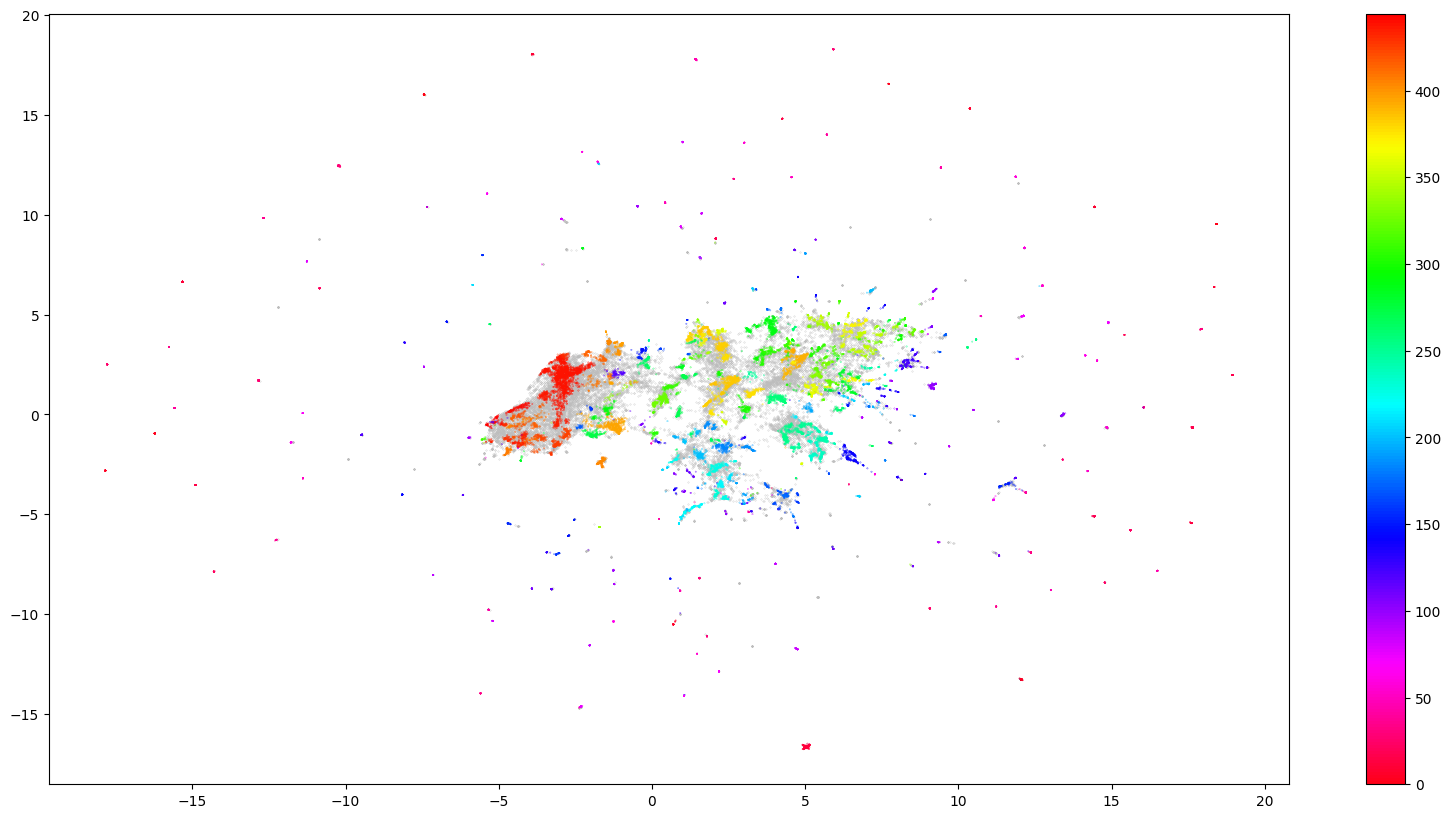

In [ ]:
from matplotlib import pyplot as plt
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [ ]:
# Topic Creation

In [ ]:
#create a single document for each cluster of documents
docs_df = pd.DataFrame(sentences,  columns=["translated_comment"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'translated_comment': ' '.join})

In [ ]:
import numpy as np

In [ ]:
# create class-based TF-IDF score

from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.translated_comment.values, m=len(sentences))

C:\Users\Yayun Li\AppData\Local\Temp\ipykernel_24560\3461442236.py:9: RuntimeWarning: invalid value encountered in divide
  tf = np.divide(t.T, w)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Topic Representation: take the top 20 words per topic based on their c-TF-IDF scores

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .translated_comment
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "translated_comment": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


,Topic,Size
0,-1,24482
439,438,1635
12,11,706
395,394,494
386,385,430
259,258,382
289,288,382
30,29,295
143,142,284
327,326,281


In [ ]:
top_n_words[439][:10]

[('energy', 0.3084696873249269),
 ('recommend', 0.25246202591933226),
 ('electricity', 0.23547996503629615),
 ('companies', 0.2028778956225299),
 ('supplier', 0.1998997157486799),
 ('talk', 0.17857060081352125),
 ('friends', 0.16332787998116013),
 ('don', 0.12958722062178532),
 ('company', 0.11867318090265037),
 ('discuss', 0.09554047444090613)]

In [ ]:
top_n_words[12][:10]

[('satisfied', 2.474669146821075),
 ('basically', 0.055060143281567296),
 ('žska', 0.0),
 ('essennt', 0.0),
 ('essence', 0.0),
 ('essen', 0.0),
 ('essant', 0.0),
 ('esra', 0.0),
 ('especially', 0.0),
 ('escaping', 0.0)]

In [ ]:
top_n_words[395][:10]

[('time', 0.24772141896420397),
 ('power', 0.23978751642120014),
 ('outage', 0.2363616661007324),
 ('earlier', 0.22508096953304324),
 ('announced', 0.20145529728181907),
 ('notified', 0.16309710254429619),
 ('turned', 0.15195362736314355),
 ('exactly', 0.14925391141154118),
 ('work', 0.13954340555802347),
 ('started', 0.12874196988938752)]

In [ ]:
top_n_words[386][:10]

[('online', 0.45555009670640123),
 ('didn', 0.37434753183312103),
 ('branch', 0.2306762472841758),
 ('internet', 0.16287625120149055),
 ('biggest', 0.08473477360785395),
 ('don', 0.0773147019844798),
 ('fast', 0.06463762107896708),
 ('great', 0.059822310031360064),
 ('handled', 0.05786998833125143),
 ('transcription', 0.05781679248274128)]

In [ ]:
import pickle

with open('top_n_words_dictionary.pkl', 'wb') as f:
    pickle.dump(top_n_words, f)

In [ ]:
with open('top_n_words_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

loaded_dict[439][:10]

[('energy', 0.3084696873249269),
 ('recommend', 0.25246202591933226),
 ('electricity', 0.23547996503629615),
 ('companies', 0.2028778956225299),
 ('supplier', 0.1998997157486799),
 ('talk', 0.17857060081352125),
 ('friends', 0.16332787998116013),
 ('don', 0.12958722062178532),
 ('company', 0.11867318090265037),
 ('discuss', 0.09554047444090613)]

In [1]:
#testing
from prettytable import PrettyTable

import pickle

with open('top_n_words_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

result_slice = loaded_dict[439][:10]

table = PrettyTable(['Index', 'Value'])
for i, value in enumerate(result_slice):
    table.add_row([i + 1, value])

print(table)

FileNotFoundError: [Errno 2] No such file or directory: 'top_n_words_dictionary.pkl'